<a href="https://colab.research.google.com/github/camilealheiro/Ovos-VC/blob/main/ConvNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import os

from torchvision.models import ConvNeXt_Small_Weights
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
])

In [ ]:
class EggShellDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        # img_name = self.data_frame.iloc[idx, 0]
        img_path = f"{self.root_dir}/{img_name}"
        image = Image.open(img_name).convert('L')
        measurements = self.data_frame.iloc[idx, 1:].values.astype('float')

        sample = {'image': image, 'measurements': measurements}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
train_dataset = EggShellDataset(csv_file="/content/drive/MyDrive/Ovos segmentados 2 rodada/imagem/train.csv", root_dir="/content/drive/MyDrive/Ovos segmentados 2 rodada/", transform=image_transform)
test_dataset = EggShellDataset(csv_file="/content/drive/MyDrive/Ovos segmentados 2 rodada/imagem/test.csv", root_dir="/content/drive/MyDrive/Ovos segmentados 2 rodada/", transform=image_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, num_tabular_features, num_outputs):
        super(CombinedModel, self).__init__()
        self.convnext = models.convnext_small(weights=ConvNeXt_Small_Weights.IMAGENET1K_V1)

        self.convnext.features[0][0] = nn.Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))


        self.convnext.classifier[2] = nn.Identity()

        self.tabular_net = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU()
        )

        self.combined_net = nn.Sequential(
            nn.Linear(768 + 128, 256),
            nn.ReLU(),
            nn.Linear(256, num_outputs)
        )

    def forward(self, image, tabular_data):
        image = image.float()
        tabular_data = tabular_data.float()

        image_features = self.convnext(image)
        tabular_features = self.tabular_net(tabular_data)
        combined_features = torch.cat((image_features, tabular_features), dim=1)
        output = self.combined_net(combined_features)

        return output



In [ ]:
num_tabular_features = train_dataset.data_frame.shape[1] - 1  # Número de colunas na planilha, exceto a coluna da imagem
num_outputs = 6  # Número de medidas a serem previstas

In [ ]:
model = CombinedModel(num_tabular_features, num_outputs)

# Função de perda e otimizador
criterion = nn.MSELoss()  # Usar MSELoss para regressão
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CombinedModel(
  (convnext): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((9

In [ ]:
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        images = batch['image'].to(device).float()
        tabular_data = batch['measurements'].to(device).float()

        # Forward pass
        outputs = model(images, tabular_data)
        loss = criterion(outputs, tabular_data)
        running_loss += loss.item()

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Epoch [1/10], Loss: 247.926025390625
Epoch [2/10], Loss: 87.28617858886719
Epoch [3/10], Loss: 2.0755629539489746
Epoch [4/10], Loss: 2.907526731491089
Epoch [5/10], Loss: 1.0231497287750244
Epoch [6/10], Loss: 1.431248664855957
Epoch [7/10], Loss: 1.2577898502349854
Epoch [8/10], Loss: 1.1073293685913086
Epoch [9/10], Loss: 0.5560853481292725
Epoch [10/10], Loss: 6.685389518737793


In [ ]:
# Avaliação no conjunto de teste
test_losses = []
test_r2_scores = []
test_rmse_scores = []

for epoch in range(num_epochs):
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        test_loss = 0

        for batch in test_loader:
            images = batch['image'].to(device).float()
            tabular_data = batch['measurements'].to(device).float()

            outputs = model(images, tabular_data)
            loss = criterion(outputs, tabular_data)
            test_loss += loss.item()

            y_true.extend(tabular_data.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)
        test_loss /= len(test_loader)

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        adjusted_r2_value = adjusted_r2(r2, len(y_true), num_tabular_features)

        test_losses.append(test_loss)
        test_r2_scores.append(r2)
        test_rmse_scores.append(rmse)

        print(f'Test Loss after Epoch [{epoch+1}/{num_epochs}]: {test_loss:}')
        print(f'RMSE: {rmse}, R²: {r2}, Adjusted R²: {adjusted_r2_value:}')

Test Loss after Epoch [1/10]: 0.8588404297828675
RMSE: 0.924270510673523, R²: 0.9977807933860441, Adjusted R²: 0.997747588299551
Test Loss after Epoch [2/10]: 0.8271997094154357
RMSE: 0.924270510673523, R²: 0.9977807933715563, Adjusted R²: 0.9977475882848464
Test Loss after Epoch [3/10]: 0.8052845120429992
RMSE: 0.924270510673523, R²: 0.9977807933580666, Adjusted R²: 0.9977475882711548
Test Loss after Epoch [4/10]: 0.8116564869880676
RMSE: 0.924270510673523, R²: 0.997780793347869, Adjusted R²: 0.9977475882608047
Test Loss after Epoch [5/10]: 0.8053116798400879
RMSE: 0.924270510673523, R²: 0.997780793354268, Adjusted R²: 0.9977475882672994
Test Loss after Epoch [6/10]: 0.8710041642189026
RMSE: 0.924270510673523, R²: 0.9977807933500495, Adjusted R²: 0.9977475882630179
Test Loss after Epoch [7/10]: 0.8178643941879272
RMSE: 0.9242704510688782, R²: 0.9977807933985523, Adjusted R²: 0.9977475883122463
Test Loss after Epoch [8/10]: 0.8381830334663392
RMSE: 0.924270510673523, R²: 0.997780793364

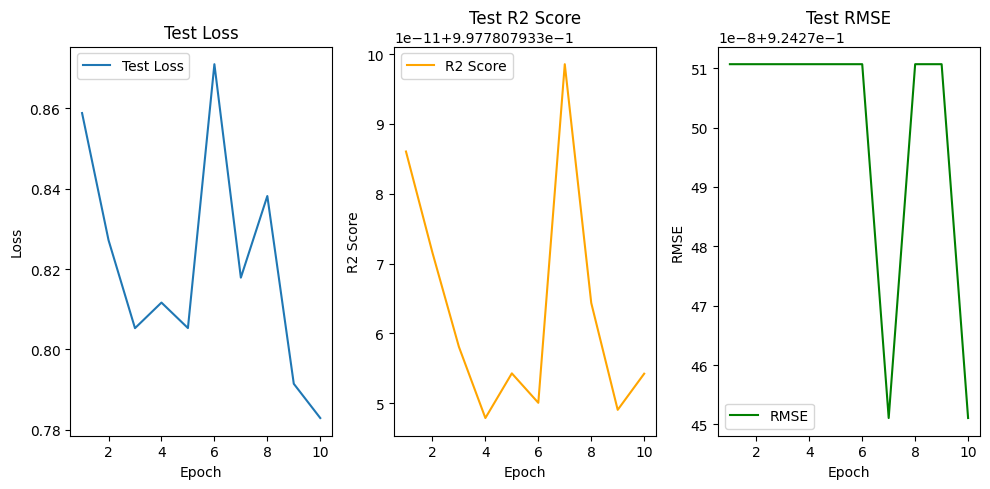

In [ ]:
import matplotlib.pyplot as plt

epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(10, 5))

# Plotando a perda
plt.subplot(1, 3, 1)
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

# Plotando o R2 score ajustado
plt.subplot(1, 3, 2)
plt.plot(epochs, test_r2_scores, label='R2 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('R2 Score')
plt.title('Test R2 Score')
plt.legend()

# Plotando o RMSE
plt.subplot(1, 3, 3)
plt.plot(epochs, test_rmse_scores, label='RMSE', color='green')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Test RMSE')
plt.legend()

plt.tight_layout()
plt.show()